# Image classification

Code for this example comes from [Chapter 1](https://colab.research.google.com/github/fastai/fastbook/blob/master/01_intro.ipynb#scrollTo=51rjRXOLDugq) of
Deep Learning for Coders with fastai & PyTorch by Jeremy Howard and Sylvain Gugger.

## Set up

### Change the runtime

Change the Runtime to utilize the NVIDIA T4 GPU, if it is not already set to the GPU.

In the menu above click
Runtime $\rightarrow$ Change runtime type and change Hardware accelerator to T4 GPU

### Import the `fastai` library

Import all items from `fastai.vision.all`

In [1]:
from fastai.vision.all import *

Import all items from `fastcore.all`

In [2]:
from fastcore.all import *

## Domain problem

We want to develop a model to classify the class/type of flower shown in an image.

## Analytic approach

We will take a predictive approach in this problem. We will train a classifier that can predict the type of flowers in an image from the following 5 categories: chamomile, tulip, rose, sunflower, dandelion

# Flowers Recognition

The data are from the [Kaggle Flower Recognition](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition?select=flowers).

In [3]:
import kagglehub
from fastai.vision.all import Path

# Download latest version
path = Path(kagglehub.dataset_download("alxmamaev/flowers-recognition")) # Convert to Path object

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2


Note: you will need to change/specify the file path if code does not work because of the incorrect path error

In [4]:
path.ls()

(#1) [Path('/root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers')]

In [5]:
%cd {path}/flowers
!ls

/root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers
daisy  dandelion  rose	sunflower  tulip


Look at a few images

In [6]:
file_names = get_image_files(path/'flowers')

In [7]:
file_names

(#4317) [Path('/root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers/tulip/13561908485_7e4f8d508b.jpg'),Path('/root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers/tulip/2489638840_72ff3ee527_n.jpg'),Path('/root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers/tulip/4516198427_0e5099cd8e.jpg'),Path('/root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers/tulip/14866400927_3a59899df3_m.jpg'),Path('/root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers/tulip/14275234071_6e6f473356.jpg'),Path('/root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers/tulip/3455026124_d66cafb9fc.jpg'),Path('/root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers/tulip/8585102511_fc452e6700_n.jpg'),Path('/root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers/tulip/5633266048_4f4bfb2cf1_n.jpg'),Path('/root/

In [8]:
f'We have {len(file_names)} images'

'We have 4317 images'

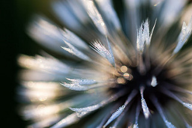

In [9]:
# select an example image
img = PILImage.create(file_names[3333]) # Change the number here to pick a different image

# plot the image
img.to_thumb(192)

## Data processing

The image labels in this problem will be derived from the folders in which we find the images.

Processing of the images (input) and annotations (output) will be done at the same time as we set up the neural network model that we will use to perform image classification. The neural network will require a particular image size for all input images, so we will need to resize the images.

### Process the images

Load the image data used to train and test the network.

First create a `DataBlock` that describes how the data should be loaded, transformed,  and what type of task it will be used for.

In [10]:
# Define a DataBlock for image classification
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),    # From the example code
    get_items = get_image_files,                            # From the example code
    splitter = RandomSplitter(valid_pct=0.30, seed=42),     # Split 30% of data for validation, the example used defalt 20% (seed=42)
    get_y = parent_label,                                   # Use the folder name as the label
    item_tfms = Resize(450, pad_mode='zeros'),              # From the example code
    batch_tfms = aug_transforms(size=224, max_warp=0.)     # From the example code
)

Load the data

In [11]:
dls = dblock.dataloaders(path/'flowers', bs=32)

## Exploratory data analysis

Our exploratory data analysis consists of examining example images. We can use the `show_batch()` method to show a few images and their labels.


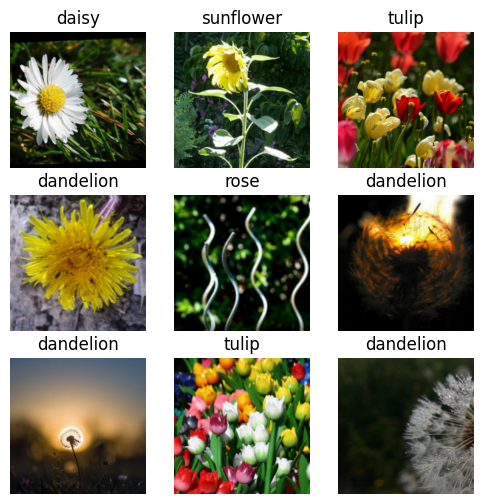

In [12]:
dls.show_batch(figsize=(6, 6))

## Modeling

We will use a deep neural network to build the classification model. Rather than training a network from scratch, we will modify an existing deep neural network to solve the problem of recognizing flower classiications.

The model will be based on the ResNet-34 deep neural network that was trained on the [ImageNet](https://www.image-net.org/) dataset.

![picture](https://storage.googleapis.com/kaggle-datasets-images/6978/10038/d9e74a548a8cdca167b38520ac8bf405/data-original.png?t=2017-12-13-20-32-53)

The ImageNet data set consists of images of many types.

We will use transfer learning to train the network to classify images.


### Train and test the model

We will train a model to classify images as five classes: daisy, dandelion, rose, sunflower, tulip, starting from the resnet34 model that has already been trained to solve an image classification problem involing many types of images.

We create a `vision_learner` object by specifying:

(1) the data loader created above `dls`,

(2) the name of the neural network we want to use as the basis for the model `resnet34`, and

(3) the metric we want to use to evaluate the performance of the model `error_rate`.

We can then fine tune the weights of the model to perform our specific task by minimizing the error for a specified number of epochs.

In [13]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

In [14]:
learn.fine_tune(epochs=15)

epoch,train_loss,valid_loss,error_rate,time
0,0.870539,0.406553,0.125097,00:26


epoch,train_loss,valid_loss,error_rate,time
0,0.447168,0.295229,0.098069,00:28
1,0.303863,0.271096,0.081853,00:30
2,0.251523,0.299095,0.093436,00:29
3,0.219707,0.295923,0.082625,00:27
4,0.181993,0.303293,0.079537,00:27
5,0.162768,0.268360,0.074903,00:27
6,0.124669,0.297858,0.066409,00:27
7,0.097357,0.255356,0.062548,00:28
8,0.075316,0.237724,0.061776,00:27
9,0.046144,0.243349,0.063320,00:27


### Assess model performance

fast.ai has a `ClassificationInterpretation` function to help analyze the performance of the model.

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

Plot the confusion matrix, which shows the number of images in the validation set that were correctly and incorrectly classified by the model.

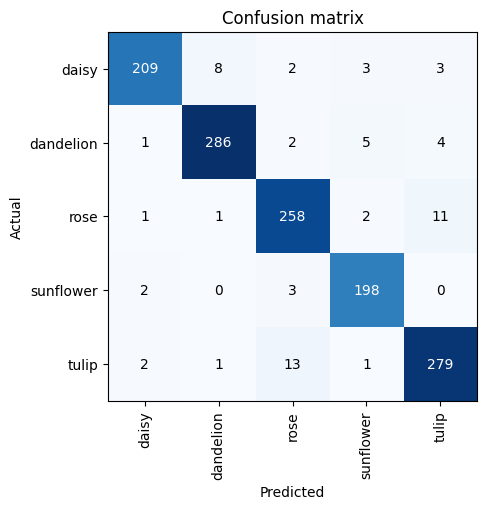

In [16]:
interp.plot_confusion_matrix(figsize=(5,5))

Show the classification report

In [17]:
interp.print_classification_report()

              precision    recall  f1-score   support

       daisy       0.97      0.93      0.95       225
   dandelion       0.97      0.96      0.96       298
        rose       0.93      0.95      0.94       273
   sunflower       0.95      0.98      0.96       203
       tulip       0.94      0.94      0.94       296

    accuracy                           0.95      1295
   macro avg       0.95      0.95      0.95      1295
weighted avg       0.95      0.95      0.95      1295



### Show the top loss images

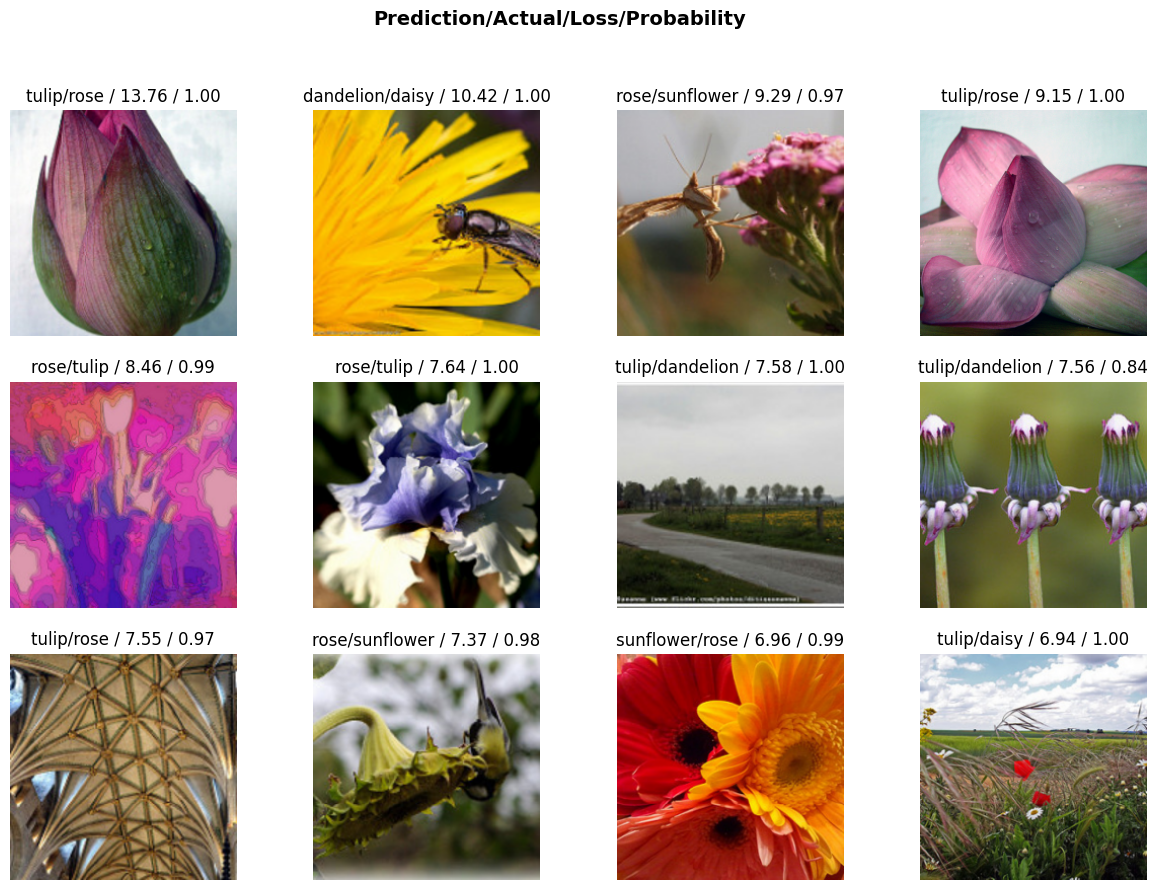

In [18]:
interp.plot_top_losses(12, figsize=(15, 10))

Note: the dataset seems to have minor error, e.g., an image of rose is stored in 'Tulip' folder; an image of sunflower is stored in 'Rose' folder. As a result, even correct predictions are counted as incorrect. For example, take a look at the file path below for the first and second images shown above.

In [19]:
# Get the indices of the top 2 images with the highest loss
top_losses_indices = interp.top_losses(2)[1]

# Get the filename using the index from the validation dataset for the first image
filename_1 = dls.valid_ds.items[top_losses_indices[0].item()]

# Get the filename using the index from the validation dataset for the second image
filename_2 = dls.valid_ds.items[top_losses_indices[1].item()]


print(f"The filename of the image with the highest loss is: {filename_1}")
print(f"The filename of the image with the second highest loss is: {filename_2}")

The filename of the image with the highest loss is: /root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers/rose/2535466393_6556afeb2f_m.jpg
The filename of the image with the second highest loss is: /root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers/daisy/34283602490_b61f3da99d_n.jpg


## Deployment

We can use the model to predict the flower type for an example image and plot the class probabilities.

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

Predicted flower: daisy
Probability it is this flower is daisy: 0.999940


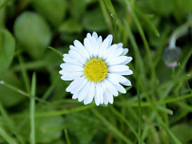

In [21]:
img = PILImage.create(file_names[1111])

prediction, _, probs = learn.predict(img)

print(f"Predicted flower: {prediction}")
print(f"Probability it is this flower is daisy: {probs[0].item():.6f}")
img.to_thumb(192)

Let's see what it predicts for a picture of [Skagit Valley Tulip Festival](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Skagit_Valley_1.JPG/500px-Skagit_Valley_1.JPG) from Wikipedia

>



![picture](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Skagit_Valley_1.JPG/500px-Skagit_Valley_1.JPG)



Note: you will need to change/specify the file path if code does not work because of the incorrect path error

--2025-11-06 03:52:02--  https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Skagit_Valley_1.JPG/500px-Skagit_Valley_1.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87336 (85K) [image/jpeg]
Saving to: ‘/tmp/Skagit_Valley.jpg’

/tmp/Skagit_Valley. 100%[===================>]  85.29K  --.-KB/s    in 0.04s   

2025-11-06 03:52:02 (1.99 MB/s) - ‘/tmp/Skagit_Valley.jpg’ saved [87336/87336]



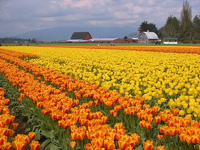

In [22]:
# Download the image to /tmp/
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Skagit_Valley_1.JPG/500px-Skagit_Valley_1.JPG -O /tmp/Skagit_Valley.jpg

# create the image from the downloaded file
img = PILImage.create('/tmp/Skagit_Valley.jpg')

# plot the image
img.to_thumb(200)

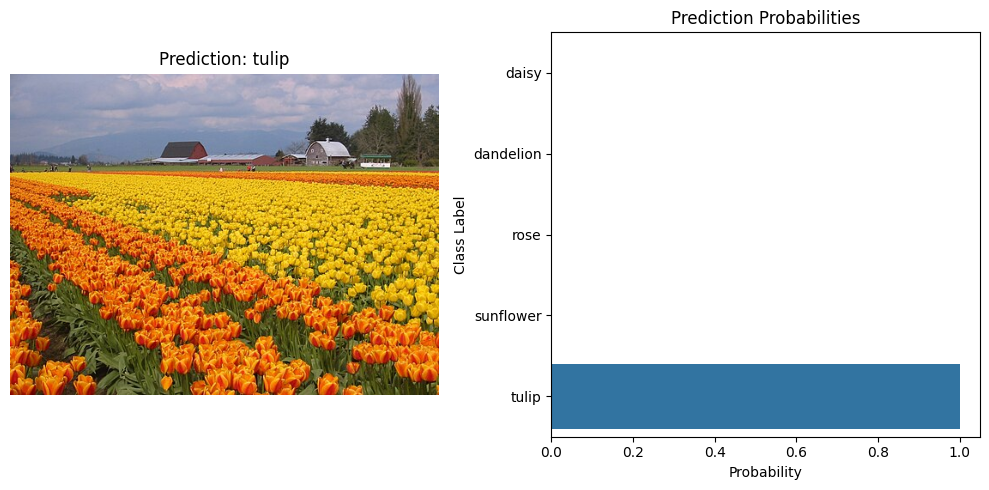

In [23]:
prediction, _, probs = learn.predict(img)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the image in the first subplot
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title(f"Prediction: {prediction}")

# Display the bar plot in the second subplot
sns.barplot(x=probs, y=dls.vocab, orient='h', ax=axes[1])
axes[1].set_xlabel("Probability")
axes[1].set_ylabel("Class Label")
axes[1].set_title("Prediction Probabilities")

plt.tight_layout()
plt.show()

Let's see what it predicts for a picture of [Sunflowers (Van Gogh series)](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Vincent_Willem_van_Gogh_127.jpg/200px-Vincent_Willem_van_Gogh_127.jpg) from Wikipedia

>



![picture](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Vincent_Willem_van_Gogh_127.jpg/200px-Vincent_Willem_van_Gogh_127.jpg)



--2025-11-06 03:52:02--  https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Vincent_Willem_van_Gogh_127.jpg/800px-Vincent_Willem_van_Gogh_127.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 269652 (263K) [image/jpeg]
Saving to: ‘/tmp/Gogh_sunflower.jpg’

/tmp/Gogh_sunflower 100%[===================>] 263.33K  --.-KB/s    in 0.07s   

2025-11-06 03:52:02 (3.48 MB/s) - ‘/tmp/Gogh_sunflower.jpg’ saved [269652/269652]



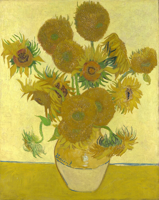

In [24]:
# Download the image to /tmp/
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Vincent_Willem_van_Gogh_127.jpg/800px-Vincent_Willem_van_Gogh_127.jpg -O /tmp/Gogh_sunflower.jpg

# create the image from the downloaded file
img = PILImage.create('/tmp/Gogh_sunflower.jpg')

# plot the image
img.to_thumb(200)

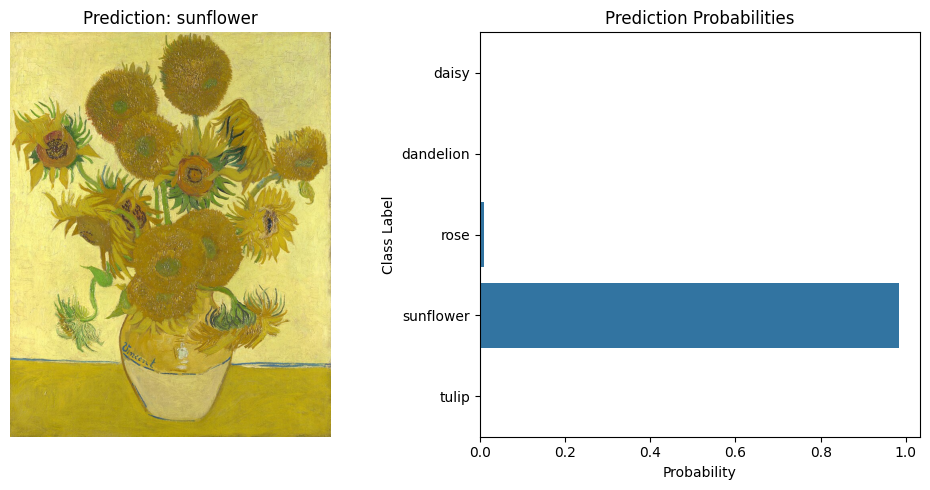

In [25]:
prediction, _, probs = learn.predict(img)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the image in the first subplot
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title(f"Prediction: {prediction}")

# Display the bar plot in the second subplot
sns.barplot(x=probs, y=dls.vocab, orient='h', ax=axes[1])
axes[1].set_xlabel("Probability")
axes[1].set_ylabel("Class Label")
axes[1].set_title("Prediction Probabilities")

plt.tight_layout()
plt.show()

Let's try another version of [Sunflowers (Van Gogh series)](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Vincent_Willem_van_Gogh_123.jpg/200px-Vincent_Willem_van_Gogh_123.jpg) from Wikipedia, which depicts both roses and sunflowers.

>



![picture](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Vincent_Willem_van_Gogh_123.jpg/200px-Vincent_Willem_van_Gogh_123.jpg)


--2025-11-06 03:52:03--  https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Vincent_Willem_van_Gogh_123.jpg/1280px-Vincent_Willem_van_Gogh_123.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 361022 (353K) [image/jpeg]
Saving to: ‘/tmp/Gogh_roses_sunflower.jpg’

/tmp/Gogh_roses_sun 100%[===================>] 352.56K  --.-KB/s    in 0.08s   

2025-11-06 03:52:03 (4.11 MB/s) - ‘/tmp/Gogh_roses_sunflower.jpg’ saved [361022/361022]



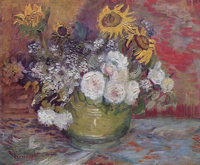

In [26]:
# Download the image to /tmp/
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Vincent_Willem_van_Gogh_123.jpg/1280px-Vincent_Willem_van_Gogh_123.jpg -O /tmp/Gogh_roses_sunflower.jpg

# create the image from the downloaded file
img = PILImage.create('/tmp/Gogh_roses_sunflower.jpg')

# plot the image
img.to_thumb(200)

Predicted flower: rose
Probability it is this flower is rose: 0.660261
Probability it is this flower is sunflower: 0.338465


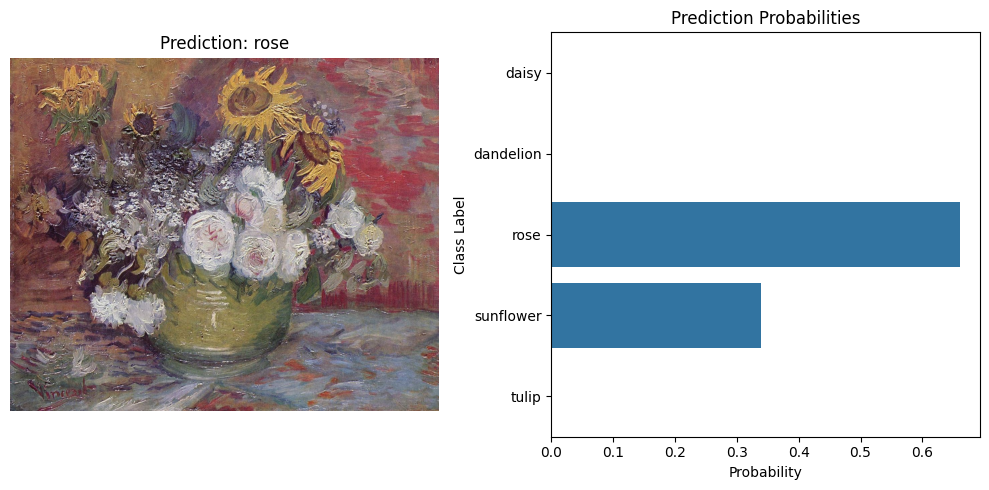

In [27]:
prediction, _, probs = learn.predict(img)

print(f"Predicted flower: {prediction}")
print(f"Probability it is this flower is rose: {probs[2].item():.6f}")
print(f"Probability it is this flower is sunflower: {probs[3].item():.6f}")
img.to_thumb(192)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the image in the first subplot
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title(f"Prediction: {prediction}")

# Display the bar plot in the second subplot
sns.barplot(x=probs, y=dls.vocab, orient='h', ax=axes[1])
axes[1].set_xlabel("Probability")
axes[1].set_ylabel("Class Label")
axes[1].set_title("Prediction Probabilities")

plt.tight_layout()
plt.show()


## Evaluation

Do we fully understand how the model is classifying the images? Are you confident that the model will be robust?

1.   The confusion matrix showed that more distinctive classes like sunflowers and dandelions were recognized with high reliability, while visually similar flowers, such as roses and tulips, were occasionally misclassified.

2.  The classification report shows that the model demonstrates excellent overall performance, with precision and recall exceeding 0.93 across all flower categories. In particular, it shows near-perfect classification for dandelions and sunflowers. However, there are minor inaccuracies with roses and daisies, suggesting that additional data augmentation or model fine-tuning for these classes could be beneficial.

1.  The highest-loss examples revealed a small number of mislabeled or visually challenging images. Some flowers photographed way to close/zoomed in or with complex backgrounds, which is more prone to misclassification.

2.   The model achieved high accuracy, indicating that it effectively learned to distinguish among the five flower categories.

1.   provided the model with new images it had never seen before to test its ability to classify flower types. When the image contained only a single type of flower, the model achieved perfect accuracy, correctly identifying the flower every time. It also successfully recognized flower types from illustrations, not just real photographs.

2.   I tested the model with an image containing multiple types of flowers. The title of the illustration was “Roses and Sunflowers.” In this case, the model predicted a probability of approximately 0.65 for rose and 0.35 for sunflower.

To sum up, the trained model demonstrated strong overall performance on the validation dataset, supported by both quantitative and qualitative analysis. The model achieved high accuracy, indicating that it effectively learned to distinguish among the five flower categories.